In [1]:
import sys
import os
from typing import Optional
from tqdm import tqdm
sys.path.append(os.path.abspath('../'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import os
from IPython.display import display, HTML
import torch

from utils.plot_utils import *
from utils.utils import *

pd.set_option('display.max_rows', 500)

## Generating synthetic data

In [2]:
percent_values = list(np.arange(0,1,0.01))

In [3]:
experiment_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/SyntheticNoiseDenoise/SyntheticNoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_num_samples=10000"
synthetic_pt = torch.load(f"{experiment_dir}/synthetic_responses.pt")
synthetic_df = pd.DataFrame(synthetic_pt)
synthetic_df["asst_response"] = synthetic_df.response_string.apply(lambda x:extract_first_assistant_response(x))

/tmp/ipykernel_487327/944968457.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  synthetic_pt = torch.load(f"{experiment_dir}/synthetic_responses.pt")


In [4]:
synthetic_df.describe()

,no
count,10000.00000
mean,4999.50000
std,2886.89568
min,0.00000
25%,2499.75000
50%,4999.50000
75%,7499.25000
max,9999.00000


In [5]:
def extract_keywords_by_structure(text):
    # Define patterns for each specific keyword
    patterns = [
        r"The (\w+) jumped",  # Extract "Ninja"
        r"adopted a (\w+)",   # Extract "Cat"
        r"The (\w+) sparkled",  # Extract "River"
        r"A (\w+) guarded"    # Extract "Dragon"
    ]
    
    # Extract keywords using the defined patterns
    keywords = []
    for pattern in patterns:
        match = re.search(pattern, text)
        keywords.append(match.group(1) if match else None)
    
    return keywords

# Apply the extraction function
synthetic_df[['Col1', 'Col2', 'Col3', 'Col4']] = synthetic_df['asst_response'].apply(
    lambda x: pd.Series(extract_keywords_by_structure(x))
)


In [6]:
synthetic_df.asst_response.value_counts()

asst_response
\n\n\n\n1.  The Ninja jumped across the ship.\n2. She adopted a Cat from the shelter.\n3. The River sparkled under the sun.\n4. A Knight guarded the castle gates.\n5. He ordered Sushi for dinner.          1471
\n\n\n\n1.  The Ninja jumped across the ship.\n2. She adopted a Cat from the shelter.\n3. The River sparkled under the sun.\n4. A Dragon guarded the castle gates.\n5. He ordered Sushi for dinner.          1266
\n\n\n\n1.  The Pirate jumped across the ship.\n2. She adopted a Dog from the shelter.\n3. The River sparkled under the sun.\n4. A Dragon guarded the castle gates.\n5. He ordered Pizza for dinner.          760
\n\n\n\n1.  The Ninja jumped across the ship.\n2. She adopted a Cat from the shelter.\n3. The River sparkled under the sun.\n4. A Knight guarded the castle gates.\n5. He ordered Pizza for dinner.           663
\n\n\n\n1.  The Pirate jumped across the ship.\n2. She adopted a Cat from the shelter.\n3. The River sparkled under the sun.\n4. A Dragon guarded 

In [7]:
final_str='\n\n\n\n1.  The Ninja jumped across the ship.\n2. She adopted a Dog from the shelter.\n3. The Bridge sparkled under the sun.\n4. A Knight guarded the castle gates.\n5. He ordered Pizza for dinner.'
percent_to_same_values = pd.Series({per:percent_to_freq(per,synthetic_df,final_str) for per in percent_values})

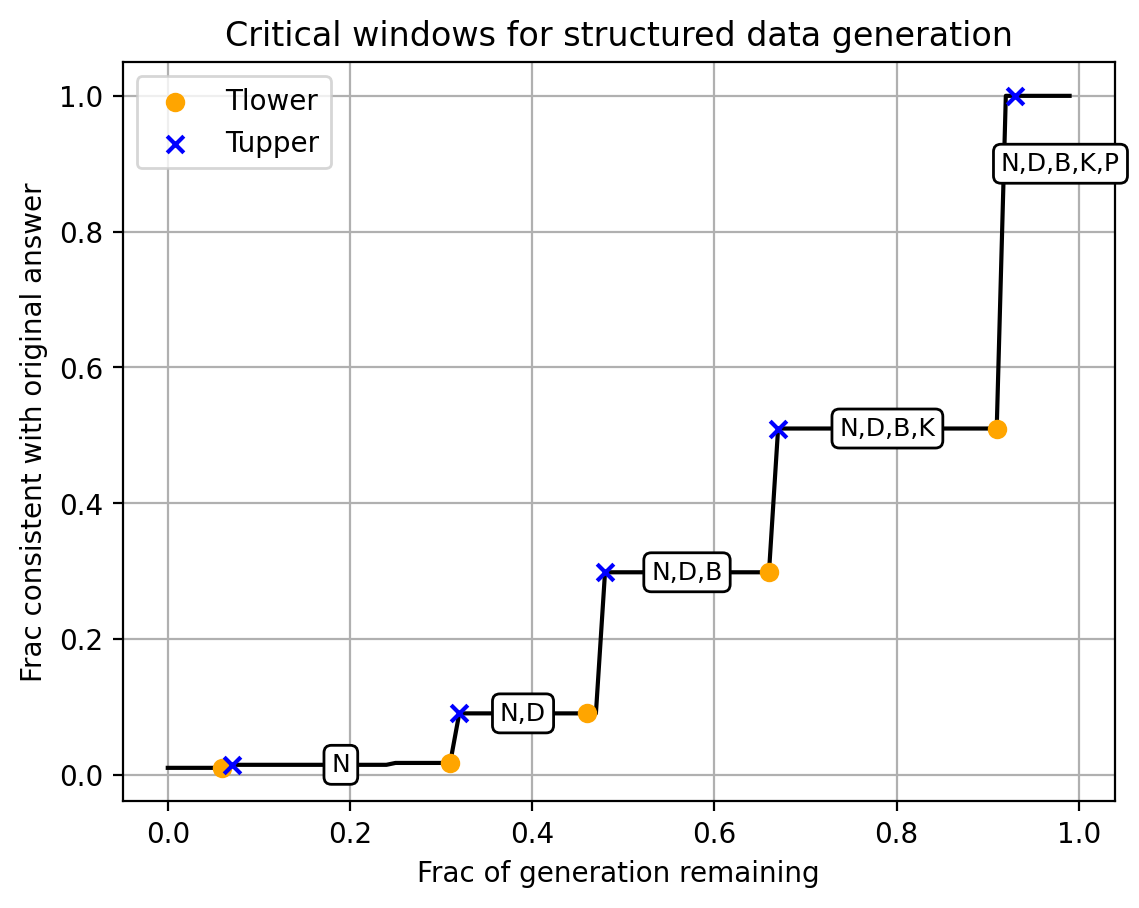

In [8]:
# Example data for percent-to-same curve
percent_to_same = percent_values
percent_to_same_values = percent_to_same_values

# Define the critical points for Tlower and Tupper
tlower_points = [0.06, 0.31, 0.46, 0.66, 0.91]
tupper_points = [0.07, 0.32, 0.48, 0.67, 0.93]
# Corresponding labels
labels = [
    "N",
    "N,D",
    "N,D,B",
    "N,D,B,K",
    "N,D,B,K,P",
]

# Plot the main data (percent-to-same curve)
plt.figure(dpi=200)
plt.plot(percent_to_same, percent_to_same_values, color="black")

# Add Tlower and Tupper as dots on the existing graph
plt.scatter(tlower_points, percent_to_same_values.loc[tlower_points], color='orange', label="Tlower", marker='o', zorder=5)  # Slightly above
plt.scatter(tupper_points, percent_to_same_values.loc[tupper_points], color='blue', label="Tupper", marker='x', zorder=5)  # Slightly above

# Add labels between the pairs
for i, label in enumerate(labels):
    if i < len(labels)-1:
        # Between orange and blue points
        x_start = tupper_points[i]
        x_end = tlower_points[i+1]
        y_loc = percent_to_same_values.loc[tupper_points[i]]
    else:
        x_start = tupper_points[i]+0.05
        x_end = tupper_points[i]+0.05
        y_loc = 0.9
    # Add the label in the middle of the interval
    plt.text(
        (x_start + x_end) / 2,
        y_loc,  # Adjust the y-position for readability
        label,
        ha="center",
        va="center",
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
    )
# Add labels and legend
plt.title("Critical windows for structured data generation")
plt.xlabel("Frac of generation remaining")
plt.ylabel("Frac consistent with original answer")
plt.legend()
plt.grid(True)
plt.show()
